In [1]:
from ase.io import read, write
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
from share.utilities import density_estimation

# Data generation

In [4]:
from ase.atoms import Atoms
from ase.build import bulk
from share.utilities import opt, label_descriptor
from quippy.potential import Potential

In [ ]:
g18_dia_e = -163.17762958500944 # reference energy for diamond-type Si measured by GAP-18

In [8]:
# make an idealised trigonal bipyramid
b=2.5
c=2.5

shift = 10
shift = 0
positions = np.array([
    [0,  0,   0],
    [0,  0,   b],
    [0,  0,  -b],
    [c,  0,  0],
    [-c*np.cos(60*np.pi/180),  c*np.sin(60*np.pi/180),  0],
    [-c*np.cos(60*np.pi/180),  -c*np.sin(60*np.pi/180),  0]
]) + shift
tbp = Atoms('Si6', cell=np.eye(3)*20, pbc=True, positions=positions)
print(tbp.get_all_distances()[0])

tbp.info['config_type'] = 'tbp'

[0.  2.5 2.5 2.5 2.5 2.5]


In [9]:
#idealised square-based pyramid

c=2.5
b=np.sqrt(2.5**2 - (c/4)**2)
shift = 10
positions = np.array([
    [0,  0,   c/4],
    [0,  0,   c*1.25],
    [0,  b,  0],
    [0, -b,  0],
    [b,  0,  0],
    [-b,  0,  0]
]) + shift
sbp = Atoms('Si6', cell=np.eye(3)*20, pbc=True, positions=positions)
print(sbp.get_all_distances()[0])

sbp.info['config_type'] = 'sbp'

[0.  2.5 2.5 2.5 2.5 2.5]


In [45]:
# make a tetrahedron Atoms object with random displacements,
# then add atom for idealised floating bond
a = 2.357167; a=2.5
ta = 180*np.arccos(-1/3)/np.pi
an1 = ta - 90
shift=10
tdpos = np.array([
    [0,  0,   0],
    [0,  0,   a],
    [a*np.cos(an1*np.pi/180),  0,  -a*np.sin(an1*np.pi/180)],
    
    [-a*np.cos(60*np.pi/180)*np.cos(an1*np.pi/180), 
     a*np.sin(60*np.pi/180)*np.cos(an1*np.pi/180),  
     -a*np.sin(an1*np.pi/180)],

    [-a*np.cos(60*np.pi/180)*np.cos(an1*np.pi/180),
     -a*np.sin(60*np.pi/180)*np.cos(an1*np.pi/180),
     -a*np.sin(an1*np.pi/180)]]) 

fb = Atoms('Si6', cell=np.eye(3)*20, pbc=True,
            positions=np.vstack((tdpos, [-a*np.cos(an1*np.pi/180), 
                                 0, 
                                -a*np.sin(an1*np.pi/180)])) + shift)

In [18]:
comps = [tbp, sbp]
comp_labels = ['tbp', 'sbp']

In [19]:
desc_str =  'soap l_max=8 n_max=16 \
                   atom_sigma=0.3 cutoff=2.7 \
                   cutoff_transition_width=0.1 central_weight=1.0'

In [20]:
comps_descs = label_descriptor(comps, desc=desc_str)
comps_descs = np.array(comps_descs)

In [46]:
fb_descs = label_descriptor(fb, desc=desc_str)
fb_descs = np.array(fb_descs)

produced by calculating SOAP vectors according to descriptor above 
with QUIP on large-memory machine. 
Trust for now.

In [67]:
# this is a 4-fold reduced dataset from the paper so it's small enough to go on github
with open('data/aSi_1Matom_defectSOAP_thinned.pickle', 'rb') as f:
    a1M_11Ks_5s_soap_project = pickle.load(f)
a1M_11Ks_5s_soap_project = np.array(a1M_11Ks_5s_soap_project)

In [68]:
tbp_ksproj = np.einsum('lj,ij', comps_descs[:, 0, :], a1M_11Ks_5s_soap_project[:, :])**4

In [69]:
fb_ksproj = np.einsum('lj,ij', fb_descs[:, :], a1M_11Ks_5s_soap_project[:, :])**4

# Plotting

[Text(0, 0.5, 'Similarity to trigonal bipyramid'),
 Text(0.5, 0, 'Similarity to floating bond')]

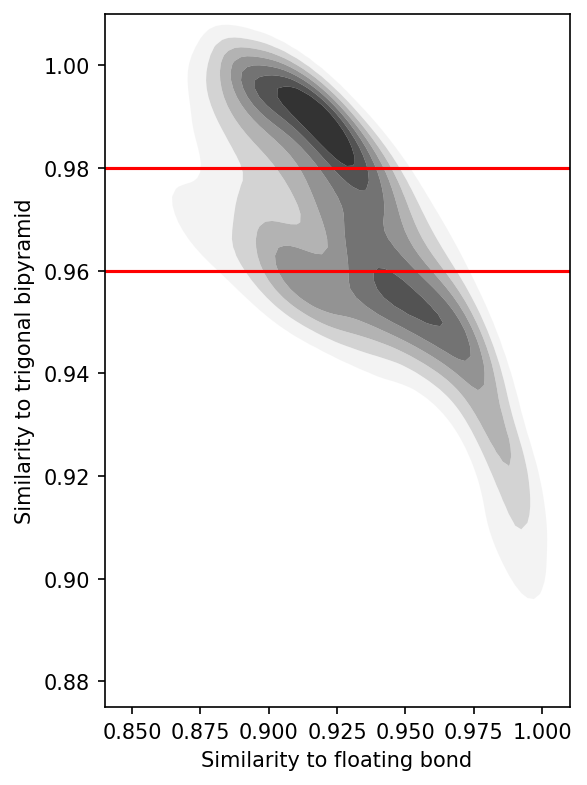

In [70]:
fig, axs = plt.subplots(dpi=150, figsize=(4, 6))
chmaster = [0]
ks1 = tbp_ksproj[:, 0:1]
ks2 = fb_ksproj
bins=500
cs = ['k'] + sns.color_palette('colorblind') + sns.color_palette('deep') + sns.color_palette('muted') + sns.color_palette('mako')
csp = cs
gray_par = 0.4980392156862745
gray = np.array([1.4, 1.4, 1.4, 1]) * np.array([gray_par]*3 + [1.0])
alphas = 0.9*np.ones(len(ks))
comp_labels = np.arange(31)
XYZ = None
if XYZ == None:
    Xks = []; Yks = []; Zks = []
else:
    Xks = XYZ[0]; Yks = XYZ[1]; Zks = XYZ[2]

zorders = np.linspace(1.0, 0.1, 100)
ct = 0
shift=6
h1 = np.histogram(ks1, bins=bins, density=True, range=(0.55, 1.01))
for i in range(ks2.shape[1]):  
    if i in chmaster:
        h1 = np.histogram(ks1, bins=bins, density=True, range=(0.55, 1.01))
        h2 = np.histogram(ks2[:, i], bins=bins, density=True, range=(0.55, 1.01))
        xs = ks1.T; ys = ks2[:, i].T
        xmin = xs.min()-0.02; xmax = xs.max()+0.02
        ymin = ys.min()-0.02; ymax = ys.max()+0.02
        if Xks == []:
            Xk, Yk, Zk = density_estimation(ys, xs, ymin, ymax, xmin, xmax)
            Xks.append(Xk); Yks.append(Yk); Zks.append(Zk)
            
        cmap_i = np.array(sns.light_palette(csp[i], n_colors=7))

        axs.contourf(Xks[ct], Yks[ct], Zks[ct], 
                     levels=np.linspace(50, 300, 7),
                     colors=cmap_i[0:], alpha=0.8,
                     zorder=zorders[ct], extend='max',
                     antialiased=True)
        ct += 1

axs.set(xlim=(0.84, 1.01), ylim=(1-(1-0.84)*6/4, 1.049))
axs.set(xlim=(0.84, 1.01), ylim=(0.875, 1.01))
axs.axhline(0.98, c='r')
axs.axhline(0.96, c='r')
    
axs.set(ylabel='Similarity to trigonal bipyramid',
        xlabel='Similarity to floating bond')